# **Simulazione e confronto degli agenti Rule-Based Controller**

Questa simulazione prende gli algoritmi RBC forniti direttamente dalla libreria di CityLearn. Questo tipologia di agente viene utilizzata per la sua semplicità dovuta al basilare utilizzo delle dichiarazioni condizionali, andando però a perdere nell'efficenza. Tutti gli agenti vengono implementati per una architettura centralizzata, cioè un agente che controlla un intero distretto. Risulta fondamentale l'implementazione di *HourRBC* che fornisce un'interfaccia base per tutti gli RBC, nella quale è possibile per mappare le azioni per ogni ora della giornata. E' importante evidenziate che i valori definiti per ogni RBC sono risultato di una grid search (esterna all'implementazione) che ha mirato all'ottimizzazione di queste regole. Inoltre nelle azioni, tutti gli accumulatori (elettrico ed energia) vengono considerati egualmente applicando le stesse regole. Differiscono solo i dispositivi di climatizzazione.

----

### **BasicRBC**
La classe BasicRBC è un agente di controllo che opera su regole orarie per sistemi di accumulo di energia e pompe di calore, basandosi sul COP ( Coefficent of Perfomance ). Il COP è un indice di efficienza per le pompe di calore che indica quanta energia viene prodotta rispetto all'energia che viene consumata. Ad esempio, un COP di 4 significa che la pompa di calore genera 4 unità di calore per ogni unità di elettricità usata. A livello pratico, le azioni sono progettate in modo che l'agente carichi gli accumulatori del 9.1% della sua capacità massima tra le 22:00 e le 8:00, e scarichi l'8% della sua capacità massima nell'orario restante. I dispositivi di raffredamento sono impostati al 40% della potenza nominale (0.4 nello spazio delle azioni) tra le 22:00 e le 8:00, e dell'80% in ogni altra ora. I dispositivi di riscaldamento risultano inversi a quelli di raffredamento.

### **OptimizedRBC**
E' una versione ottimizata del BasicRBC, dove le azioni di controllo sono state selezionate tramite una ricerca su griglia.
Il termine "*search grid*" (ricerca su griglia) fa riferimento ad una tecnica utilizzata per ottimizzare parametri in modelli o algoritmi. In questo contesto implica l'esplorazione di diverse combinazioni di parametri di controllo per poi trovare la combinazione migliore.
Le azioni sono progettate in modo che l'agente scarichi il sistema di accumulo controllato del 2% ogni ora tra le 07:00 e le 15:00, scarichi il 4,4% ogni ora tra le 16:00 e le 18:00, scarichi il 2,4% ogni ora tra le 19:00 e le 22:00, carichi il 3,4% tra le 23:00 e mezzanotte e carichi il 5,532% ogni altra ora.
Il dispositivo di raffreddamento rende disponibile il 70,0% della sua potenza nominale ogni ora tra le 07:00 e le 15:00, il 60,0% tra le 16:00 e le 18:00, l'80,0% tra le 19:00 e le 22:00, il 40,0% tra le 23:00 e mezzanotte e il 20,0% in ogni altra ora.
I dispositivi di riscaldamento risultano inversi a quelli di raffredamento.

### **BasicBatteryRBC**
Un agente di controllo basato su HourRBC (regole orarie) progettato per sfruttare al meglio l'energia solare per la ricarica delle batterie.
Le azioni sono ottimizzate per la batteria in modo che l'agente carichi dell'11,0% della sua capacità massima ogni ora tra le 06:00 e le 14:00, e scarichi il 6,7% della sua capacità massima nelle ore restanti. Il dispositivo di raffreddamento è impostato al 70,0% della potenza nominale tra le 06:00 e le 14:00 e al 30,0% in ogni altra ora. I dispositivi di riscaldamento risultano inversi a quelli di raffredamento.

----

**Lista degli import**

In [1]:
from citylearn.agents.rbc import BasicRBC
from citylearn.agents.rbc import BasicBatteryRBC
from citylearn.agents.rbc import OptimizedRBC
from citylearn.citylearn import CityLearnEnv

#import per strutture dati
import pandas as pd
from datetime import datetime
from IPython.display import display, Markdown

#import per grafici
from utils import plotting_functions as plt

#permette di nascondere i warning
import warnings
warnings.filterwarnings("ignore")


Couldn't import dot_parser, loading of dot files will not be possible.



----

### **Esecuzione della simulazione**

Vengono creati tre ambienti da dataset uguali per eseguire in contemporanea tutti gli algoritmi di RBC

In [2]:
# Inizializza l'ambiente
# citylearn_challenge_2023_phase_2_local_evaluation è una simulazione nel mese di GIUGNO
env_name = 'citylearn_challenge_2023_phase_2_local_evaluation'
envs = [
    CityLearnEnv(env_name, central_agent=True),
    CityLearnEnv(env_name, central_agent=True),
    CityLearnEnv(env_name, central_agent=True)
]

# Inizializza gli agenti
models = [
    BasicRBC(envs[0]),
    OptimizedRBC(envs[1]),
    BasicBatteryRBC(envs[2])
]

# Resetto la simulazione per tutti gli ambienti
observations_list = [env.reset()[0] for env in envs]
#display(envs[0].unwrapped.action_names)

# Seleziona un preciso edificio nell'ambiente
num_building = 1
step=0

while not any(env.terminated for env in envs):
    actions_list = [model.predict(observations) for model, observations in zip(models, observations_list)]
    #display(actions_list)
    # Effettua uno step nella simulazione per ogni agente
    results = [env.step(actions) for env, actions in zip(envs, actions_list)]
    
    # Aggiorna le osservazioni per il prossimo step
    observations_list = [result[0] for result in results]
    step+=1
    # Ottieni i dati osservati per un solo edificio di ciascun ambiente
    #obs_data_list = [env.buildings[num_building]._get_observations_data() for env in envs]
    
    # Mostra i metadati del dispositivo di raffreddamento dell'edificio selezionato per ciascun ambiente
    #metadata_list = [env.buildings[num_building].cooling_device.get_metadata() for env in envs]
    
# Visualizza i dati osservati (facoltativo, se serve per il debug)
# display(obs_data_list)



----

## **Confronto con Baseline**
La parte seguente viene fornita direttamente dalla documentazione di CityLearn e effettua una valutazione degli algoritmi sulle **cost_function**. Come si può notare, le stastiche (che sono in rapporto al baseline) risultano sia in consumi che in discomfort peggiori in confronto all'algoritmo ideale. Inoltre a livello di performance l'unico che si discosta dagli altri è il BasicBattery, che presenta dei consumi ridotti in quanto a differenza degli altri durante la giornata tende ad accumulare energia al posto di rilasciare. Ciò migliora le prestazioni in quanto si ottimizza l'accumulo di energia solare durante la fasi più irradiate della giornata. 

In [3]:
kpis_names = { 'carbon_emissions_total':'Emissioni',
              'discomfort_proportion':'Proporzione del tempo fuori dal comfort',
              'electricity_consumption_total':'Consumo totale della rete',
              #Qua si aggiungono cost_function
}
for name, model in zip(['BasicRBC', 'OptimizedRBC', 'BasicBatteryRBC'], models):
    kpis = model.env.evaluate()
    #Commentando la riga seguente si ottiene la tabella delle cost_function completa
    kpis = kpis[(kpis['cost_function'].isin(kpis_names))].dropna()
    kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
    display(Markdown(f"### **{name}**"))
    display(Markdown("----")) 
    display(kpis) 

### **BasicRBC**

----

name,Building_1,Building_2,Building_3,District
cost_function,,,,
carbon_emissions_total,1.998,1.936,1.740,1.891
discomfort_proportion,0.975,0.907,0.957,0.946
electricity_consumption_total,1.995,1.963,1.755,1.904


### **OptimizedRBC**

----

name,Building_1,Building_2,Building_3,District
cost_function,,,,
carbon_emissions_total,1.827,1.779,1.612,1.739
discomfort_proportion,0.975,0.858,0.932,0.922
electricity_consumption_total,1.811,1.788,1.615,1.738


### **BasicBatteryRBC**

----

name,Building_1,Building_2,Building_3,District
cost_function,,,,
carbon_emissions_total,1.506,1.493,1.377,1.459
discomfort_proportion,0.940,0.604,0.586,0.710
electricity_consumption_total,1.511,1.514,1.392,1.472



------

## **Comportamento dei consumi**

Di seguito viene riportato il grafico dei consumi della rete l'elettrica, che evidenziano il concetto spiegato precedentemente. Infatti BasicRBC tende ad avere durante la fase di carica, dei consumi più elevati, che permettono però durante le ore restanti di avere dei consumi estremamente ridotti. Mentre il BasicRBC e l'OptimizedRBC tendono ad avere fra di loro differenze più ridotte. Rispetto all'algoritmo di baseline, si può notare come l'avere delle regole fisse porti i consumi ad avere dei pattern più riconoscobili, ed evidenziando la poca flessibilità dell'algoritmo. Si evidenzia che tra lo step 384 e 408 avviene un'interruzione della corrente.

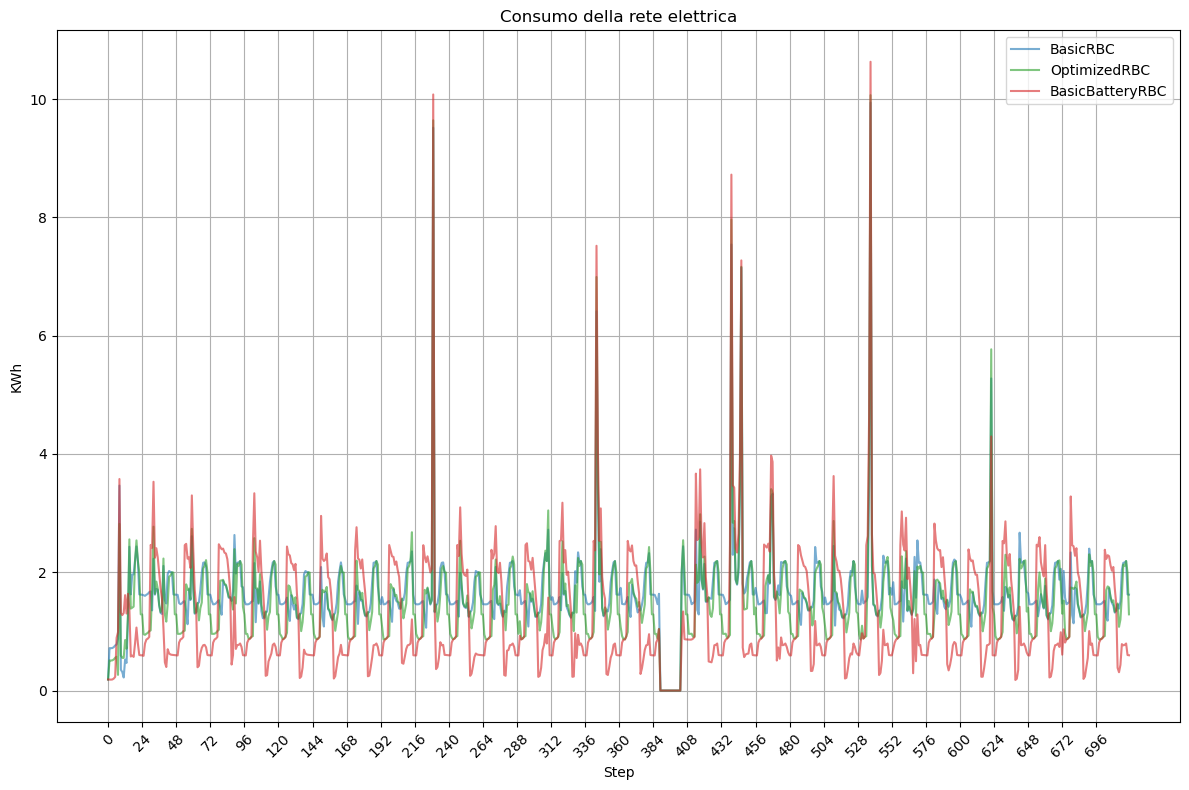

In [4]:
agent_data1 = envs[0].buildings[num_building].net_electricity_consumption
agent_data2 = envs[1].buildings[num_building].net_electricity_consumption
agent_data3 = envs[2].buildings[num_building].net_electricity_consumption

plt.plot_comparison(agent_data1, agent_data2, agent_data3, 'KWh', 'Consumo della rete elettrica')


----

## **Comportamento della temperatura**

Per quanto riguarda le temperature, i seguenti grafici mostrano l'energia utilizzata dal climatizzatore, la temperatura interna effettiva e quella di setpoint. Tutti gli algoritmi RBC presentano per l'utilizzo del dispositivo di raffredamento delle regole semplici: per ogni ora viene impostata un percentuale di potenza nominale fissa, indipendentemente dalle osservazioni dell'ambiente. I risultati in efficenza, considerando il discomfort, sono variabili dal dataset, ed in questo caso risulta migliore il BasicBatteryRBC. Ciò è dovuto al fatto che la banda di comfort di questo dataset tende a premiare il BasicBatteryRBC, che tende avere temperature più calde, e penalizzare OptimizedRBC e BasicRBC che tendono a tenere la casa più fresca. Avendo le azioni fisse ad orario non viene effettuata alcun tipo di verifica sulle temperature esterne portando ad un discomfort rilevante (in questo dataset la banda di comfort va da setpoint-2 a setpoint+2). Per quanto riguarda il OptimizedRBC e il BasicRBC, l'energia consumata dal dispositivo di raffreddamento risulta utilizzata in maniera più efficiente rispetto al BasicBatteryRBC, in quanto progettati sulla base del COP.

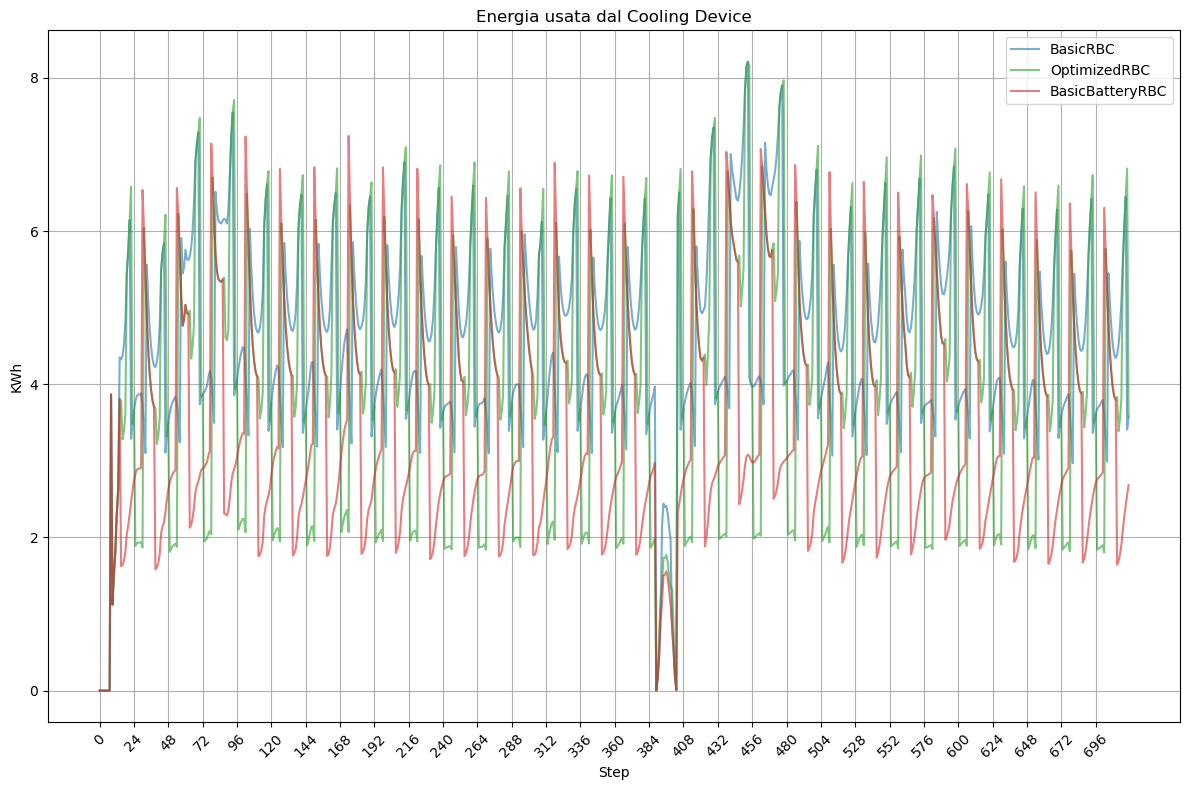

In [5]:
agent_data1 = envs[0].buildings[num_building].energy_from_cooling_device
agent_data2 = envs[1].buildings[num_building].energy_from_cooling_device
agent_data3 = envs[2].buildings[num_building].energy_from_cooling_device

plt.plot_comparison(agent_data1, agent_data2, agent_data3, 'KWh', 'Energia usata dal Cooling Device')

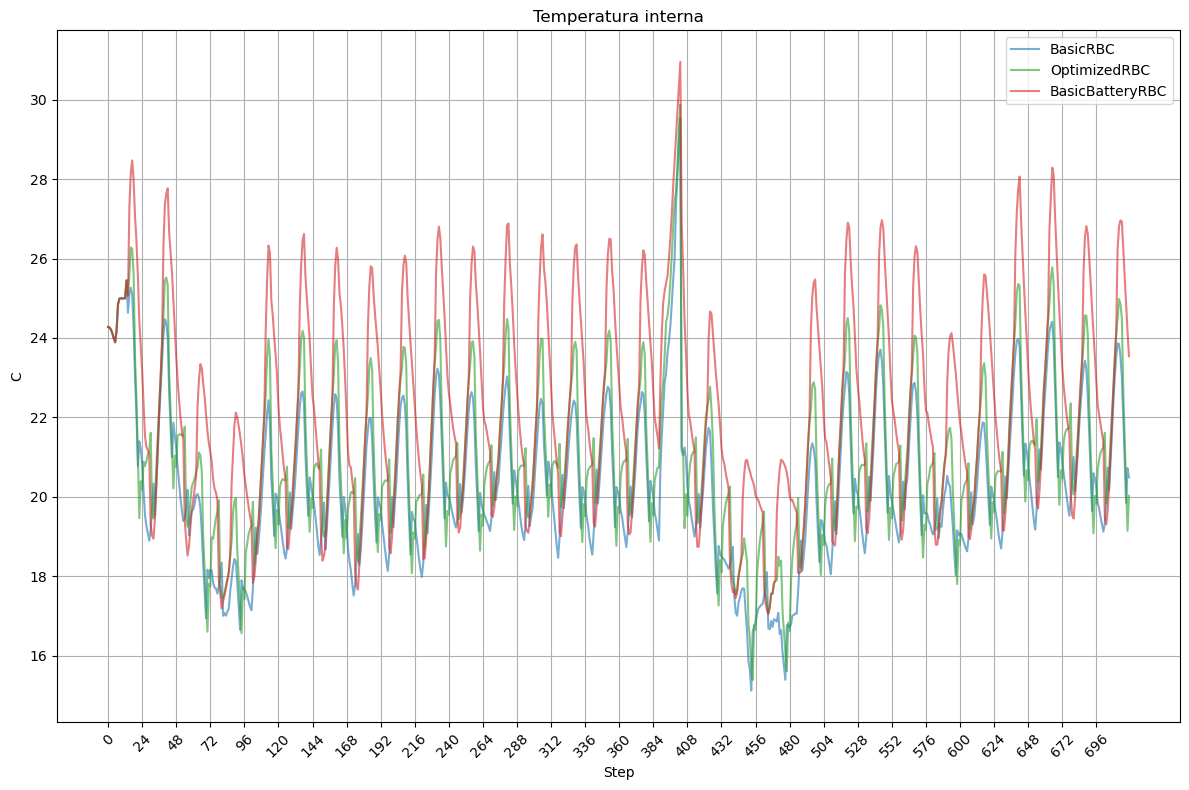

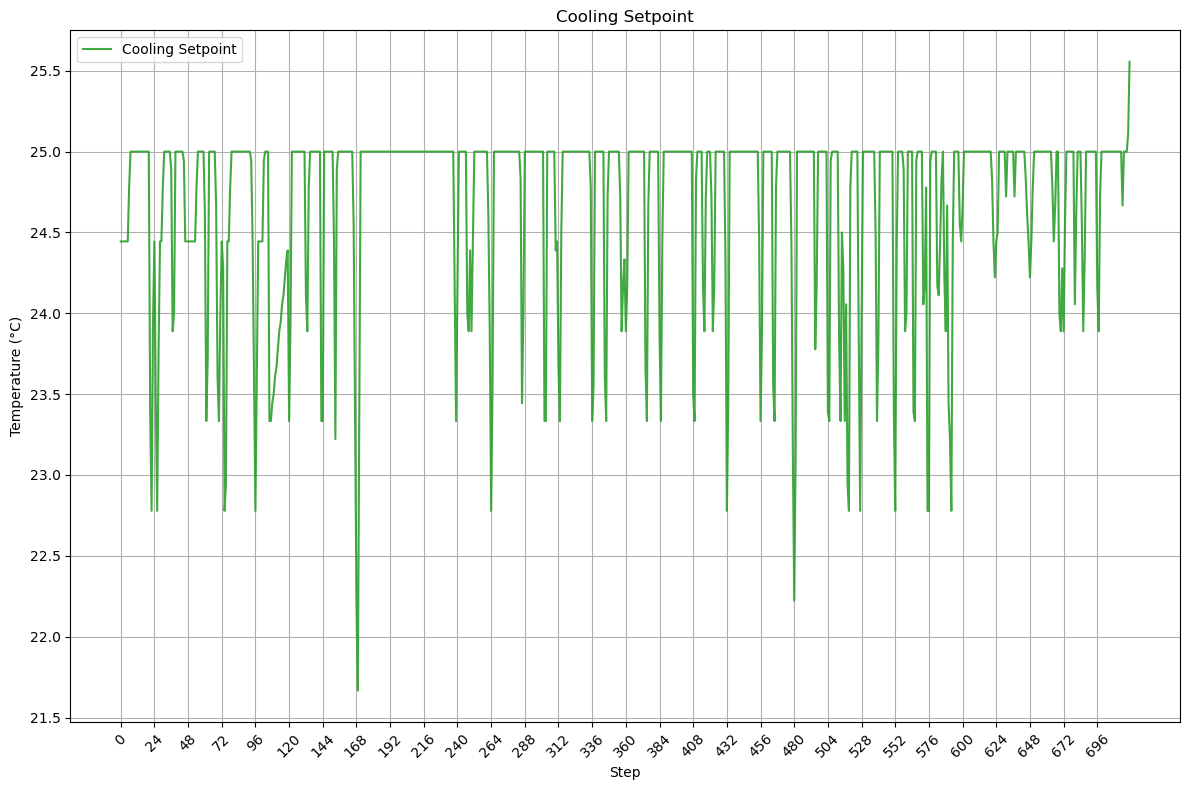

In [8]:
agent_data1 = envs[0].buildings[num_building].indoor_dry_bulb_temperature
agent_data2 = envs[1].buildings[num_building].indoor_dry_bulb_temperature
agent_data3 = envs[2].buildings[num_building].indoor_dry_bulb_temperature

plt.plot_comparison(agent_data1, agent_data2, agent_data3, 'C', 'Temperatura interna')

plt.plot_single_agent(
    agent_data=envs[0].buildings[num_building].indoor_dry_bulb_temperature_cooling_set_point,
    ylabel='Temperature (°C)',
    title='Cooling Setpoint',
    label='Cooling Setpoint'
)



----

## **Comportamento nell'utilizzo delle batterie**

Con i grafici seguenti, oltre ad evidenziare il comportamento che hanno i vari agenti con le batterie, esalta le prestazioni del BasicBatteryRBC, il quale tende ad utilizzare al meglio gli accumulatori, immagazzinando il più possibile e rilasciando in maniera modesta.


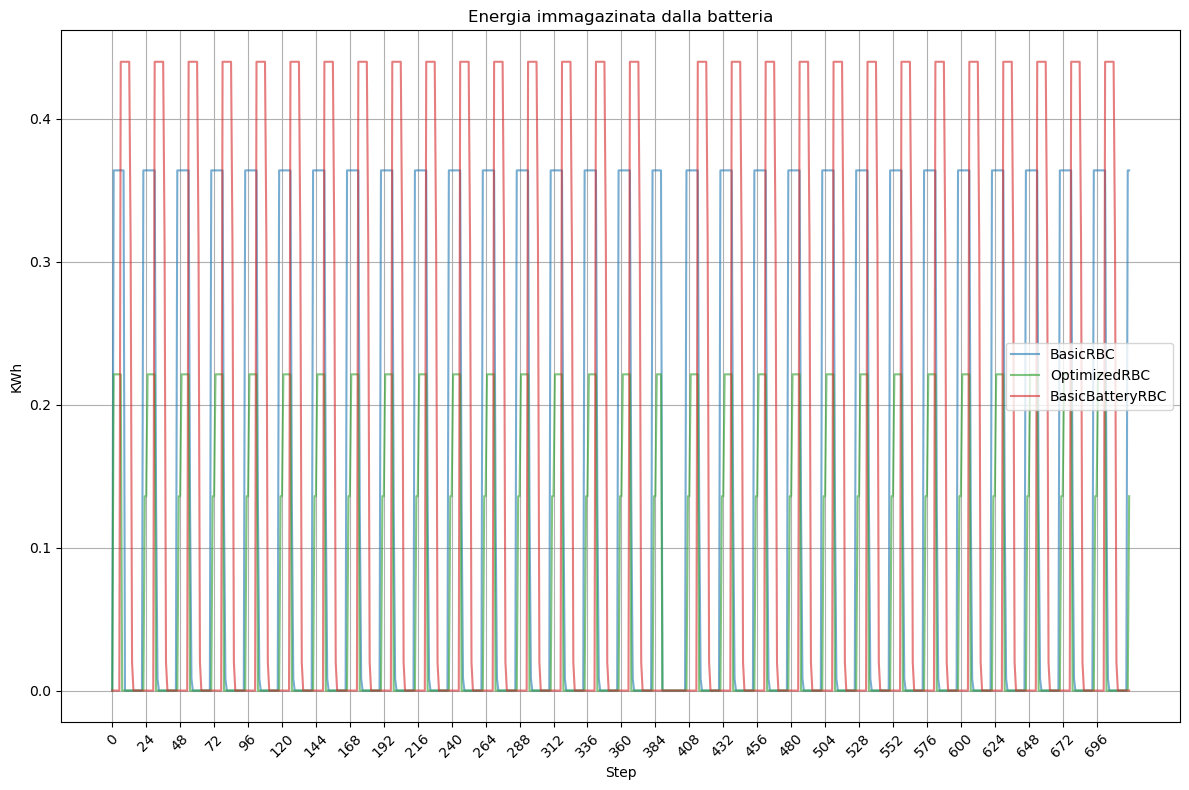

In [9]:
agent_data1 = envs[0].buildings[num_building].energy_to_electrical_storage
agent_data2 = envs[1].buildings[num_building].energy_to_electrical_storage
agent_data3 = envs[2].buildings[num_building].energy_to_electrical_storage

plt.plot_comparison(agent_data1, agent_data2, agent_data3, 'KWh', 'Energia immagazinata dalla batteria')

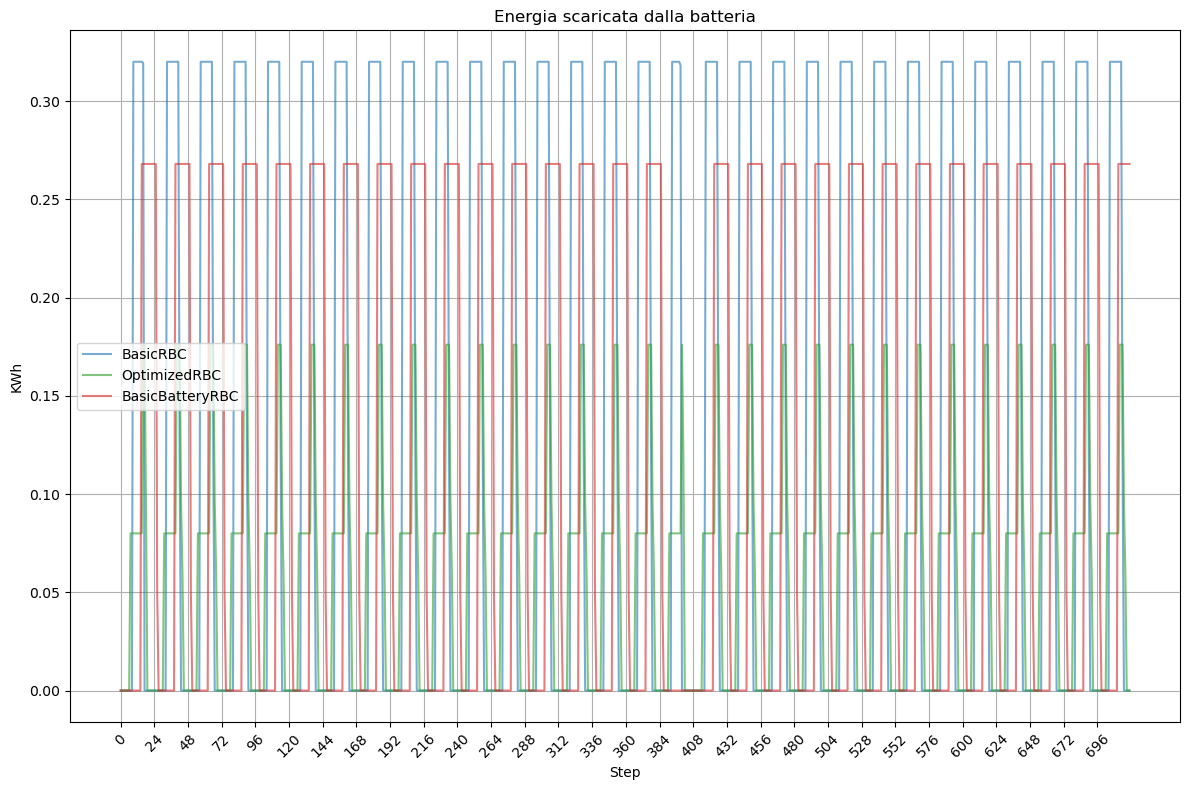

In [10]:
agent_data1 = envs[0].buildings[num_building].energy_from_electrical_storage
agent_data2 = envs[1].buildings[num_building].energy_from_electrical_storage
agent_data3 = envs[2].buildings[num_building].energy_from_electrical_storage

plt.plot_comparison(agent_data1, agent_data2, agent_data3, 'KWh', 'Energia scaricata dalla batteria')


----

## **Comportamento delle emissioni**

L'emissioni sono strettamente legate ai consumi di energia della rete, perciò le caratteristiche precedenti si propagano anche qua.

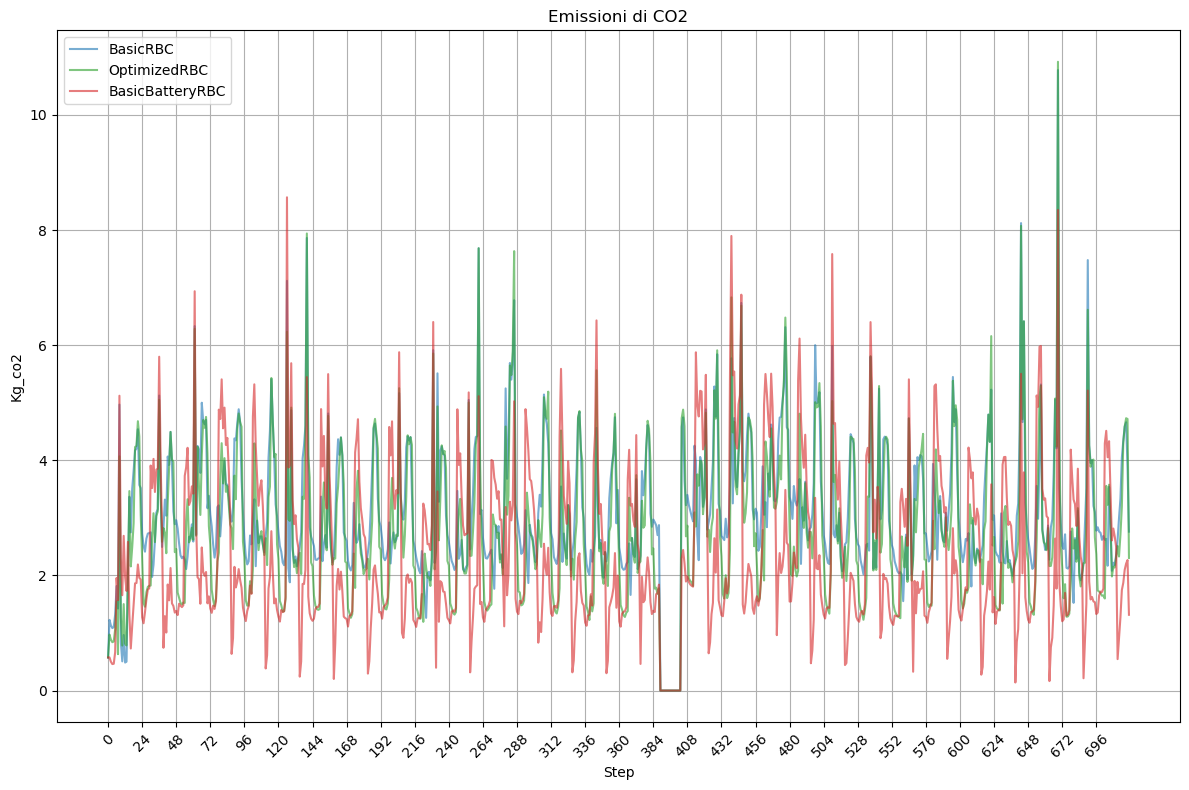

In [11]:
agent_data1 = envs[0].net_electricity_consumption_emission
agent_data2 = envs[1].net_electricity_consumption_emission
agent_data3 = envs[2].net_electricity_consumption_emission

plt.plot_comparison(agent_data1, agent_data2, agent_data3, 'Kg_co2', 'Emissioni di CO2')